**In this notebook we train the four NN architectures that involve LSTM layers for 100x100 grid.**

In [ ]:
pip install tensorflow==2.10.0
pip install matplotlib==3.7.4
pip install scipy==1.10.1
pip install pandas==2.0.3
pip install deepxde==1.10.1
pip install numpy==1.24.3
pip install scikit-learn==1.3.2

In [29]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import LSTM, Dense, Flatten, Reshape, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from keras import backend as K
from keras.callbacks import LearningRateScheduler, EarlyStopping, Callback
from keras.metrics import RootMeanSquaredError
from keras.layers import Dropout,  TimeDistributed
from keras.regularizers import l2
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Concatenate, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, losses, metrics
tf.keras.backend.set_floatx('float64')

In [30]:
# Set seeds for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Configure TensorFlow for deterministic behavior
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Control threading for reproducibility
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Ensure GPU determinism
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Define He initializer
initializer = tf.keras.initializers.HeNormal(seed=seed_value)

RuntimeError: Inter op parallelism cannot be modified after initialization.

*CUDA*

In [3]:
len(tf.config.list_physical_devices('GPU'))>0

True

*Read data*

In [31]:
sorted_concatenated_csv = "C:/Users/Giannis/Documents/uva-thesis/neural-agent-models/data/simulation data/100x100.csv"
data = pd.read_csv(sorted_concatenated_csv)
#data.drop(columns=['zCOM'], inplace=True)
print(data.head())

   mcsteps  xCOM  yCOM              il8   il1   il6  il10   tnf   tgf
0        0    78    62   [8.155469e-08]  [0.]  [0.]  [0.]  [0.]  [0.]
1        0    29    17   [3.716848e-09]  [0.]  [0.]  [0.]  [0.]  [0.]
2        0    64    24  [3.4276149e-09]  [0.]  [0.]  [0.]  [0.]  [0.]
3        0    77    16  [3.7302027e-13]  [0.]  [0.]  [0.]  [0.]  [0.]
4        0    29     7  [3.9552712e-16]  [0.]  [0.]  [0.]  [0.]  [0.]


*Replace the 'mcsteps' column with 'time' and adjust the scale to represent 0-100 hours*

In [32]:
data['time'] = (data['mcsteps'] / 10000).astype(int)
data = data[['time'] + [col for col in data.columns if col != 'time']]
data.drop(columns=['mcsteps'], inplace=True)
print(data)

       time  xCOM  yCOM              il8              il1              il6  \
0         0    78    62   [8.155469e-08]             [0.]             [0.]   
1         0    29    17   [3.716848e-09]             [0.]             [0.]   
2         0    64    24  [3.4276149e-09]             [0.]             [0.]   
3         0    77    16  [3.7302027e-13]             [0.]             [0.]   
4         0    29     7  [3.9552712e-16]             [0.]             [0.]   
...     ...   ...   ...              ...              ...              ...   
33842   100    97    49  [1.4131037e-10]  [4.0171866e-09]  [4.0206436e-12]   
33843   100    62    90   [9.426965e-08]    [5.53244e-09]  [2.3352102e-08]   
33844   100     5    83   [3.467103e-11]   [1.923624e-08]   [4.866993e-11]   
33845   100    32    17  [1.6327994e-07]  [1.9637703e-09]  [4.1984766e-10]   
33846   100    86    51   [9.620416e-07]   [6.637888e-10]  [1.8478708e-13]   

                  il10              tnf               tgf  
0  

*Create 101 arrays (1 per timestep) to prepare the data to form input/output pairs for NN*

In [33]:
# define cytokines
cytokines = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

# Remove brackets and convert to float
for col in cytokines:
    data[col] = data[col].str.strip('[]').astype(float)

# get unique time values
unique_time = data['time'].unique()

arrays = {}

# iterate over unique time values
for time in unique_time:
    # filter data for current value of time
    data_time = data[data['time'] == time]
    
    # initialize 100x100x6 array for current value of time
    array = np.zeros((100, 100, len(cytokines)))
    
    # get X and Y coordinates
    x = data_time['xCOM'].astype(int)
    y = data_time['yCOM'].astype(int)
    
    # get cytokine concentrations
    concentrations = data_time[['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']].values
    
    # assign cytokine concentrations to corresponding position in array
    array[x, y, :] = concentrations
    
    # store array for current value of time
    arrays[time] = array

*Check for errors*

In [6]:
print("Number of arrays:", len(arrays))
array = arrays[0]
print("Shape of the array:", array.shape)
print("Value at position (78,62):", array[78,62])

Number of arrays: 101
Shape of the array: (100, 100, 6)
Value at position (78,62): [8.155469e-08 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00]


*Construct a 5D tensor that contains a sequence of arrays to be input to the model and a 4D tensor for the output. We use sequence length of 10 here.*

In [17]:
sequence_length = 2
input_sequences = []
output_values = []

# convert dictionary values to a list of arrays
arrays_list = [arrays[key] for key in sorted(arrays.keys())]

# convert 'arrays' list to numpy array
arrays_np = np.array(arrays_list)

for i in range(len(arrays_np) - sequence_length):
    input_seq = arrays_np[i:i+sequence_length]  # input sequence of arrays
    output_val = arrays_np[i+sequence_length]   # array at next time step
    
    input_sequences.append(input_seq)
    output_values.append(output_val)

# convert lists to numpy arrays
input_sequences = np.array(input_sequences)
output_values = np.array(output_values)

*Check for errors*

In [8]:
print(input_sequences.shape)
print(output_values.shape)

(99, 2, 100, 100, 6)
(99, 100, 100, 6)


*Metrics (rest of metrics used are pre-defined)*

In [18]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - SS_res/(SS_tot + K.epsilon())

def average_relative_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_pred - y_true) / K.clip(K.abs(y_true), K.epsilon(), None))))

def accuracy(y_true, y_pred):
    abs_diff = K.abs(y_true - y_pred)
    threshold = 0.2 * y_true
    accurate_predictions = K.less_equal(abs_diff, threshold)
    accuracy = K.mean(accurate_predictions)
    return accuracy

**Neural Networks**

*C-LSTM: 2D convolutional layer followed by 2 LSTM layers and a FC*

In [26]:
# lr scheduler
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-4
    if epoch < 500:
        return 1e-4
    else:
        return 1e-4

# data split
train_size = int(0.72 * input_sequences.shape[0])
val_size = int(0.1 * input_sequences.shape[0])
test_size = input_sequences.shape[0] - train_size - val_size

X_train = input_sequences[:train_size]
X_val = input_sequences[train_size:train_size + val_size]
X_test = input_sequences[train_size + val_size:]
y_train = output_values[:train_size]
y_val = output_values[train_size:train_size + val_size]
y_test = output_values[train_size + val_size:]

# print shapes to check errors
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

# parameters and callbacks
initial_lr = 1e-4
optimizer = Adam(learning_rate=initial_lr)
sequence_length = 2
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
lr_scheduler_callback = LearningRateScheduler(lr_schedule)

# model architecture
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(sequence_length, 100, 100, 6)),
    Reshape((sequence_length, -1)),
    LSTM(units=100, return_sequences=True, kernel_regularizer=l2(0.03)),
    LSTM(units=100),
    BatchNormalization(),
    Dense(units=100*100*6, activation='relu'),
    Reshape((100, 100, 6))
])

# compile
model.compile(optimizer=optimizer, loss='mse',  metrics=[r_squared, 'mape', accuracy, 'msle', 'mae'])

# fit
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=32, callbacks=[early_stopping, lr_scheduler_callback])

# evaluate
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

X_train shape: (71, 2, 100, 100, 6)
X_val shape: (9, 2, 100, 100, 6)
X_test shape: (19, 2, 100, 100, 6)
y_train shape: (71, 100, 100, 6)
y_val shape: (9, 100, 100, 6)
y_test shape: (19, 100, 100, 6)
Epoch 1/1000


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/lstm_1/lstm_cell_1/kernel/Regularizer/mul' defined at (most recent call last):
    File "c:\Users\Giannis\Documents\lib\runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Giannis\Documents\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\Giannis\AppData\Roaming\Python\Python38\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\Giannis\Documents\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\Giannis\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\Giannis\AppData\Roaming\Python\Python38\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Giannis\Documents\lib\asyncio\base_events.py", line 563, in run_forever
      self._run_once()
    File "c:\Users\Giannis\Documents\lib\asyncio\base_events.py", line 1844, in _run_once
      handle._run()
    File "c:\Users\Giannis\Documents\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Giannis\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\Giannis\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\Giannis\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\Giannis\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\Giannis\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\Giannis\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\Giannis\AppData\Roaming\Python\Python38\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Giannis\Documents\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\Giannis\Documents\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\Giannis\Documents\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Giannis\Documents\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Giannis\Documents\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Giannis\Documents\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Giannis\AppData\Local\Temp\ipykernel_792\1445431590.py", line 52, in <module>
      history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=4, callbacks=[early_stopping, lr_scheduler_callback])
    File "c:\Users\Giannis\Documents\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Giannis\Documents\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Giannis\Documents\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Giannis\Documents\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Giannis\Documents\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Giannis\Documents\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\Giannis\Documents\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\Giannis\Documents\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\Giannis\Documents\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/lstm_1/lstm_cell_1/kernel/Regularizer/mul'
failed to allocate memory
	 [[{{node gradient_tape/lstm_1/lstm_cell_1/kernel/Regularizer/mul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_73026]

*CT-LSTM: more complex architecture with maxpooling, and more neurons per layer*

In [ ]:
#lr scheduler
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-3
    if epoch < 400:
        return 1e-4
    else:
        return 1e-5

#data split
train_size = int(0.7 * len(input_sequences))
val_size = int(0.1 * len(input_sequences))

X_train, y_train = input_sequences[:train_size], output_values[:train_size]
X_val, y_val = input_sequences[train_size:train_size+val_size], output_values[train_size:train_size+val_size]
X_test, y_test = input_sequences[train_size+val_size:], output_values[train_size+val_size:]

# model architecture 
def build_model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    
    
    x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))(input_layer)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    
    x = layers.Reshape((input_shape[0], -1))(x)
    x = layers.LSTM(128, return_sequences=True,kernel_regularizer=l2(0.01))(x)
    x = layers.LSTM(64)(x)
    
    x = layers.Dense(100 * 100 * 6, activation='relu')(x)
    output_layer = layers.Reshape((100, 100, 6))(x)
    
    model = models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

#parameters and callbacks
input_shape = (sequence_length, 100, 100, 6)
model = build_model(input_shape)
lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1, restore_best_weights=True)
initial_lr = 1e-3

#compile
model.compile(optimizer='adam', loss='mse', metrics=[r_squared, 'mape', 'accuracy', average_relative_rmse, 'msle', 'mae'])

#fit
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=16, callbacks=[lr_scheduler, early_stopping])

#evaluate
test_metrics = model.evaluate(X_test, y_test)
print(f'Test Metrics: {test_metrics}')

*STA-LSTM: NN incorporating lstm layer, spatiotemporal attention layers followed by fully connected layers*

In [19]:
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-6
    if epoch < 500:
        return 1e-3
    else:
        return 1e-4

# SpatialTemporalAttention class
class SpatialTemporalAttention(tf.keras.layers.Layer):
    def __init__(self, hidden_size):
        super(SpatialTemporalAttention, self).__init__()
        self.hidden_size = hidden_size
        self.W_s = Dense(hidden_size)
        self.W_t = Dense(hidden_size)
        self.V = Dense(1)

    def call(self, lstm_output, input_data):
        spatial_attention = tf.tanh(self.W_s(lstm_output))
        temporal_attention = tf.tanh(self.W_t(input_data))
        attention_scores = self.V(spatial_attention * temporal_attention)
        attention_weights = tf.nn.softmax(attention_scores, axis=1)
        attended_output = tf.matmul(tf.transpose(attention_weights, [0, 2, 1]), lstm_output)
        return attended_output

class STALSTM(tf.keras.Model):
    def __init__(self, hidden_size, input_shape):
        super(STALSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = LSTM(hidden_size, return_sequences=True)
        self.attention = SpatialTemporalAttention(hidden_size)
        self.fc1 = Dense(50, activation='relu', kernel_regularizer=l2(0.01))
        self.fc2 = Dense(50, activation='relu', kernel_regularizer=l2(0.01))
        self.batch_norm = BatchNormalization()
        self.fc3 = Dense(tf.reduce_prod(input_shape[1:]), activation='relu')
        self.reshape = Reshape(input_shape[1:])
        self.input_shape_model = input_shape

    def call(self, input_data):
        lstm_output = self.lstm(input_data)
        attended_output = self.attention(lstm_output, input_data)
        x = tf.reshape(attended_output, (-1, self.hidden_size))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.batch_norm(x)
        output = self.fc3(x)
        output = self.reshape(output)
        return output

# Reshape input sequences
input_sequences_reshaped = input_sequences.reshape(input_sequences.shape[0], input_sequences.shape[1], -1)
print(input_sequences_reshaped.shape)

# Data split
train_size = int(0.72 * input_sequences_reshaped.shape[0])
val_size = int(0.1 * input_sequences_reshaped.shape[0])
test_size = input_sequences_reshaped.shape[0] - train_size - val_size

X_train = input_sequences_reshaped[:train_size]
X_val = input_sequences_reshaped[train_size:train_size + val_size]
X_test = input_sequences_reshaped[train_size + val_size:]
y_train = output_values[:train_size]
y_val = output_values[train_size:train_size + val_size]
y_test = output_values[train_size + val_size:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

input_shape = input_sequences.shape[1:]
print(input_shape)

# Initialize the model
model = STALSTM(hidden_size=64, input_shape=input_shape)

# Build the model by calling it on a batch of data
sample_input = tf.convert_to_tensor(X_train[:1])
_ = model(sample_input)

# Parameters and callbacks
lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=40, verbose=1, restore_best_weights=True)
initial_lr = 1e-6

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='mse', metrics=[r_squared, 'mape', accuracy, 'msle', 'mae'])

print(model.summary())

# Train the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=4, validation_data=(X_val, y_val), callbacks=[lr_scheduler, early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

(99, 2, 60000)
X_train shape: (71, 2, 60000)
X_val shape: (9, 2, 60000)
X_test shape: (19, 2, 60000)
y_train shape: (71, 100, 100, 6)
y_val shape: (9, 100, 100, 6)
y_test shape: (19, 100, 100, 6)
(2, 100, 100, 6)
Model: "stalstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 multiple                  15376640  
                                                                 
 spatial_temporal_attention   multiple                 3844289   
 (SpatialTemporalAttention)                                      
                                                                 
 dense_3 (Dense)             multiple                  3250      
                                                                 
 dense_4 (Dense)             multiple                  2550      
                                                                 
 batch_normalization (BatchN  multiple      

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Reshape
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.regularizers import l2

# Learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-6
    if epoch < 500:
        return 1e-3
    else:
        return 1e-4

# SpatialTemporalAttention class
class SpatialTemporalAttention(tf.keras.layers.Layer):
    def __init__(self, hidden_size):
        super(SpatialTemporalAttention, self).__init__()
        self.hidden_size = hidden_size
        self.W_s = Dense(hidden_size)
        self.W_t = Dense(hidden_size)
        self.V = Dense(1)

    def call(self, lstm_output, input_data):
        spatial_attention = tf.tanh(self.W_s(lstm_output))
        temporal_attention = tf.tanh(self.W_t(input_data))
        attention_scores = self.V(spatial_attention * temporal_attention)
        attention_weights = tf.nn.softmax(attention_scores, axis=1)
        attended_output = tf.matmul(tf.transpose(attention_weights, [0, 2, 1]), lstm_output)
        return attended_output

# STALSTM model class with BatchNormalization
class STALSTM(tf.keras.Model):
    def __init__(self, hidden_size, input_shape):
        super(STALSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = LSTM(hidden_size, return_sequences=True)
        self.attention = SpatialTemporalAttention(hidden_size)
        self.fc1 = Dense(50, activation='relu', kernel_regularizer=l2(0.01))
        self.fc2 = Dense(50, activation='relu', kernel_regularizer=l2(0.01))
        self.batch_norm = BatchNormalization()
        self.fc3 = Dense(tf.reduce_prod(input_shape[1:]), activation='relu')
        self.reshape = Reshape(input_shape[1:])
        self.input_shape_model = input_shape

    def call(self, input_data):
        lstm_output = self.lstm(input_data)
        attended_output = self.attention(lstm_output, input_data)
        x = tf.reshape(attended_output, (-1, self.hidden_size))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.batch_norm(x)
        output = self.fc3(x)
        output = self.reshape(output)
        return output

# Reshape input sequences
input_sequences_reshaped = input_sequences.reshape(input_sequences.shape[0], input_sequences.shape[1], -1)
print(input_sequences_reshaped.shape)

# Data split
train_size = int(0.7 * input_sequences_reshaped.shape[0])
val_size = int(0.1 * input_sequences_reshaped.shape[0])
test_size = input_sequences_reshaped.shape[0] - train_size - val_size

X_train = input_sequences_reshaped[:train_size]
X_val = input_sequences_reshaped[train_size:train_size + val_size]
X_test = input_sequences_reshaped[train_size + val_size:]
y_train = output_values[:train_size]
y_val = output_values[train_size:train_size + val_size]
y_test = output_values[train_size + val_size:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

input_shape = input_sequences.shape[1:]
print(input_shape)

# Initialize the model
model = STALSTM(hidden_size=64, input_shape=input_shape)

# Build the model by calling it on a batch of data
sample_input = tf.convert_to_tensor(X_train[:1])
_ = model(sample_input)

# Parameters and callbacks
lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=40, verbose=1, restore_best_weights=True)
initial_lr = 1e-6

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='mse', metrics=[r_squared, 'mape', accuracy, average_relative_rmse, 'msle', 'mae'])

print(model.summary())

# Train the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=4, validation_data=(X_val, y_val), callbacks=[lr_scheduler, early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

(99, 2, 60000)
X_train shape: (69, 2, 60000)
X_val shape: (9, 2, 60000)
X_test shape: (21, 2, 60000)
y_train shape: (69, 100, 100, 6)
y_val shape: (9, 100, 100, 6)
y_test shape: (21, 100, 100, 6)
(2, 100, 100, 6)
Model: "stalstm_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               multiple                  15376640  
                                                                 
 spatial_temporal_attention_  multiple                 3844289   
 6 (SpatialTemporalAttention                                     
 )                                                               
                                                                 
 dense_39 (Dense)            multiple                  4160      
                                                                 
 dense_40 (Dense)            multiple                  4160      
                                          

*LSTM: neural network with 3 stacked lstm layers and 4 fully connected layers*

In [ ]:
#lr scheduler
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-2
    if epoch < 500:
        return 1e-3
    else:
        return 1e-4
    
#parameters and callbacks
lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1, restore_best_weights=True)

initial_lr = 1e-2
sequence_length =10

input_sequences_reshaped = input_sequences.reshape(input_sequences.shape[0], input_sequences.shape[1], -1)

#data split
train_size = int(0.7 * input_sequences_reshaped.shape[0])
val_size = int(0.1 * input_sequences_reshaped.shape[0])
test_size = input_sequences_reshaped.shape[0] - train_size - val_size

X_train = input_sequences_reshaped[:train_size]
X_val = input_sequences_reshaped[train_size:train_size + val_size]
X_test = input_sequences_reshaped[train_size + val_size:]
y_train = output_values[:train_size]
y_val = output_values[train_size:train_size + val_size]
y_test = output_values[train_size + val_size:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

#model architecture
model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(sequence_length, 100 * 100 * 6), kernel_regularizer=l2(0.03))) 
model.add(LSTM(units=256, return_sequences=True, input_shape=(sequence_length, 100 * 100 * 6), kernel_regularizer=l2(0.03)))
model.add(LSTM(units=256))
model.add(Dense(units=256, kernel_regularizer=l2(0.03)))
model.add(Dense(units=256, kernel_regularizer=l2(0.03)))
model.add(Dense(units=256, kernel_regularizer=l2(0.03)))
model.add(Dense(units=100 * 100 * 6, activation='relu'))
model.add(Reshape((100, 100, 6)))
model.compile(optimizer=Adam(learning_rate=initial_lr), loss='mse', metrics=[r_squared, 'mape', accuracy, average_relative_rmse, 'msle', 'mae'])
print(model.summary())

history = model.fit(X_train, y_train, epochs=1000, batch_size=100, validation_data=(X_val, y_val), callbacks=[lr_scheduler, early_stopping])
print("Training Loss:", history.history['loss'])

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

*export in CSV the prediction for test set*

In [21]:
y_pred = model.predict(X_test)

y_pred_shape = y_pred.shape
y_test_shape = y_test.shape

# Create arrays for x and y coordinates
X = np.arange(y_test_shape[1])
Y = np.arange(y_test_shape[2])

# Initialize a list to hold all data for the DataFrame
all_data = []

# Loop through each timestep and collect the data
for timestep in range(y_pred_shape[0]):
    for i in X:
        for j in Y:
            if not np.all(y_pred[timestep, i, j] == 0):  # Only include non-zero entries
                data_point = {'timestep': timestep, 'x': i, 'y': j}
                data_point.update({f'feature_{k+1}': y_pred[timestep, i, j, k] for k in range(y_pred_shape[-1])})
                all_data.append(data_point)

# Create the DataFrame with the correct columns
df_all_timesteps = pd.DataFrame(all_data, columns=['timestep', 'x', 'y', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6'])

# Save the DataFrame to a CSV file
csv_path = 'C:/Users/Giannis/Documents/STA-LSTM(100x100)(82-100hrs).csv'
df_all_timesteps.to_csv(csv_path, index=False)

print(f"Data saved to {csv_path}")

1/1 [==============================] - 1s 507ms/step
Data saved to C:/Users/Giannis/Documents/STA-LSTM(100x100)(82-100hrs).csv


*Plot and export training data*

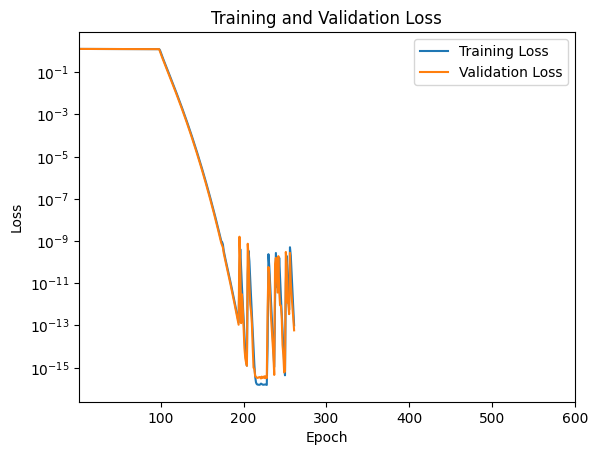

Loss data saved to plots(100x100)/plots-CT-LSTM\CT-LSTM-loss_data.csv


In [23]:
train_loss = history.history['loss'][1:600]
val_loss = history.history['val_loss'][1:600]

output_dir = 'plots(100x100)/plots-CT-LSTM'
os.makedirs(output_dir, exist_ok=True)

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.xlim(1, 600)  # Force the x-axis scale to be from 1 to 1500
plot_filename = f'loss.png'
plot_path = os.path.join(output_dir, plot_filename)
plt.savefig(plot_path)
plt.show()

# Exporting the data for loss to a CSV file
loss_data = {
    'Epoch': list(range(1, len(train_loss) + 1)),  # Adjusting the length to match the loss data
    'Training Loss': train_loss,
    'Validation Loss': val_loss
}
loss_df = pd.DataFrame(loss_data)
csv_filename = 'CT-LSTM-loss_data.csv'
csv_path = os.path.join(output_dir, csv_filename)
loss_df.to_csv(csv_path, index=False)

print(f'Loss data saved to {csv_path}')

*Compute means and standard deviation and plot timeseries*

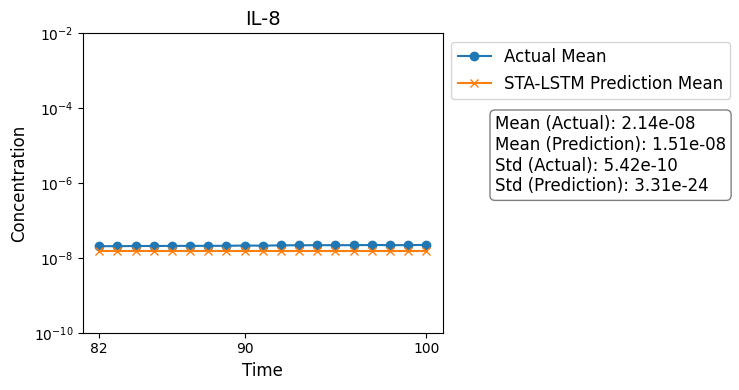

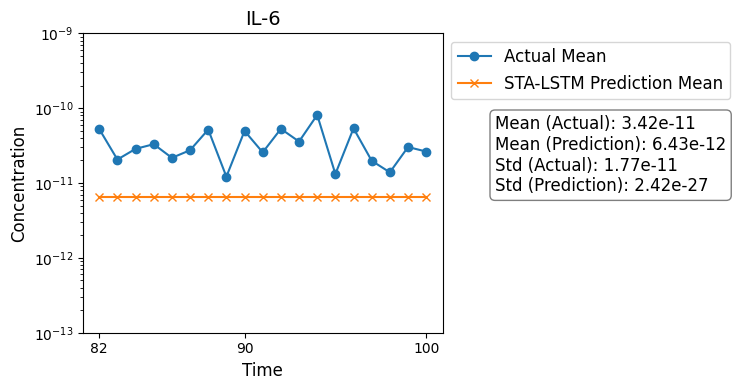

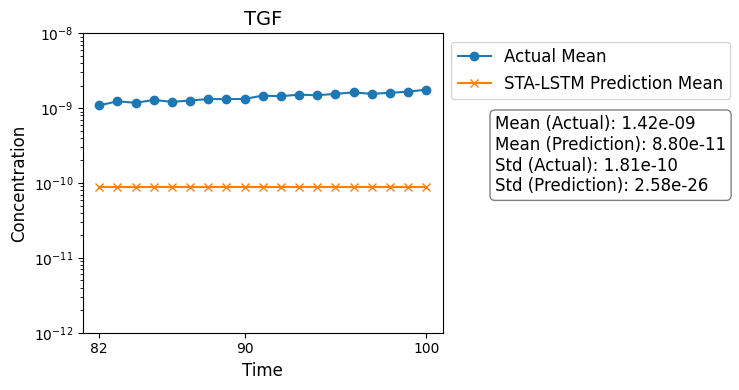

In [25]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Combine y_test and y_pred for easier range calculation
combined_data = np.concatenate([y_test, y_pred])

output_dir = 'plots-PINN'
os.makedirs(output_dir, exist_ok=True)

# Mask zeros and small values, set lower limit for log scale
masked_data = np.ma.masked_equal(combined_data, 0)
lower_limit = 1e-13
upper_limit = 1e-2

# Calculate min and max values for each cytokine, ignoring zeros and clipping
min_values = np.ma.min(masked_data, axis=(0, 1, 2))
max_values = np.ma.max(masked_data, axis=(0, 1, 2))

# Convert masked arrays to regular arrays with NaN where masked
min_values = min_values.filled(np.nan)
max_values = max_values.filled(np.nan)

# Average over the spatial dimensions (X, Y coordinates)
y_test_avg = np.mean(y_test, axis=(1, 2))
y_pred_avg = np.mean(y_pred, axis=(1, 2))

# Calculate mean and std for each cytokine across all time steps
y_test_mean = np.mean(y_test_avg, axis=0)
y_pred_mean = np.mean(y_pred_avg, axis=0)
y_test_std = np.std(y_test_avg, axis=0)
y_pred_std = np.std(y_pred_avg, axis=0)

# Time steps (assuming they are from t=82 to t=100)
time_steps = np.arange(82, 101)
selected_time_steps = [82, 90, 100]

# Labels and corresponding indices to plot
labels_to_plot = ['IL-8', 'IL-6', 'TGF']
indices_to_plot = [0, 2, 5]  # indices for 'IL-8', 'IL-6', 'TGF' in the original labels list
custom_limits = [(1e-10, 1e-2), (1e-13, 1e-9), (1e-12, 1e-8)]

# Plotting each selected feature separately
for i, label, (lower, upper) in zip(indices_to_plot, labels_to_plot, custom_limits):
    plt.figure(figsize=(10, 4))
    plt.plot(time_steps, y_test_avg[:, i], label='Actual Mean', marker='o')
    plt.plot(time_steps, y_pred_avg[:, i], label='STA-LSTM Prediction Mean', marker='x')

    plt.ylabel('Concentration', fontsize=12)
    plt.yscale('log')
    plt.ylim(lower, upper)
    
    plt.xticks(selected_time_steps)
    
    # Display means and stds numerically outside the plot
    textstr = '\n'.join((
        f'Mean (Actual): {y_test_mean[i]:.2e}',
        f'Mean (Prediction): {y_pred_mean[i]:.2e}',
        f'Std (Actual): {y_test_std[i]:.2e}',
        f'Std (Prediction): {y_pred_std[i]:.2e}',
    ))
    plt.gcf().text(0.5, 0.7, textstr, fontsize=12,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    plt.xlabel('Time', fontsize=12)
    plt.title(label, fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    
    # Save the plot to the specified folder
    plot_filename = f'{label}_concentrations_time_series.png'
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path, bbox_inches='tight')
    plt.show()

*Compute prediction accuracy (in terms of cytokines distribution on the grid) by treating this as a pseudo-classification problem*

In [59]:
dataset2_path = 'data/LSTM(100x100)(72-100).csv' 

data2 = pd.read_csv(dataset2_path)

# Define cytokines
cytokines = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

# Remove brackets and convert to float in dataset 1
#for col in cytokines:
    #data[col] = data[col].str.strip('[]').astype(float)

# Filter for time = 72
data_72 = data[data['time'] == 100]
data2_72 = data2[data2['timestep'] == 100]

# Create a 100x100 grid representation for both datasets
grid_size = 100

def create_binary_grid(data, x_col, y_col, value_cols):
    grid = np.zeros((grid_size, grid_size))
    for _, row in data.iterrows():
        x, y = int(row[x_col]), int(row[y_col])
        if any(row[col] != 0 for col in value_cols):
            grid[x, y] = 1
    return grid

# Create binary grids
value_cols_data = cytokines
value_cols_data2 = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6']

grid1 = create_binary_grid(data_72, 'xCOM', 'yCOM', value_cols_data)
grid2 = create_binary_grid(data2_72, 'X', 'Y', value_cols_data2)

# Calculate accuracy
def calculate_accuracy(actual_grid, predicted_grid):
    actual_non_zero = np.sum(actual_grid)
    correct_predictions = np.sum((actual_grid == 1) & (predicted_grid == 1))
    accuracy = correct_predictions / actual_non_zero if actual_non_zero > 0 else 0
    return accuracy

accuracy = calculate_accuracy(grid1, grid2)

print(f"Accuracy of predictions for t=72: {accuracy * 100:.2f}%")

Accuracy of predictions for t=72: 61.82%


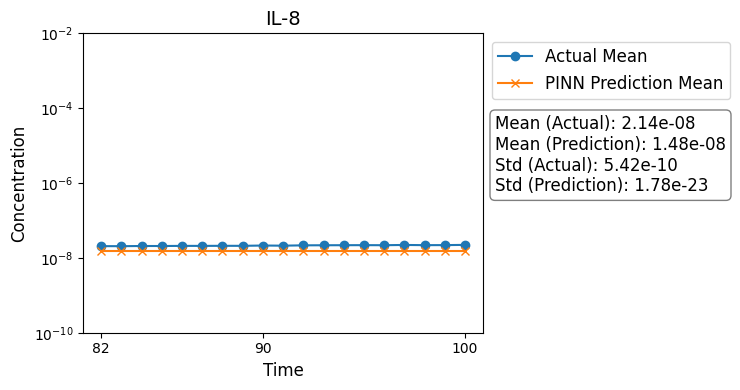

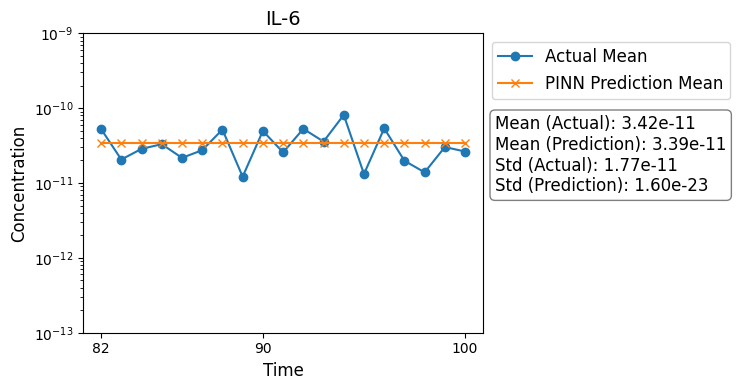

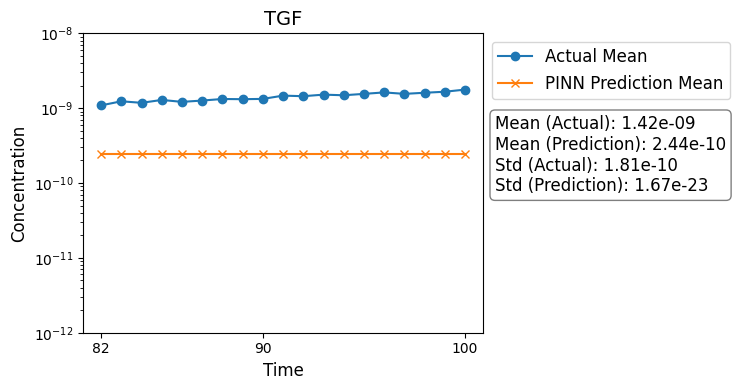

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the 'predictions' data
predictions_path = 'C:/Users/Giannis/Documents/C-LSTM(100x100)(82-100hrs).csv'
predictions = pd.read_csv(predictions_path)

# Rename columns
predictions.columns = ['time', 'xCOM', 'yCOM', 'il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

predictions['time'] = predictions['time'].map(lambda t: t + 82 if 0 <= t <= 19 else t)

filtered_data = data[(data['time'] >= 82) & (data['time'] <= 100)]

time_steps = np.arange(82, 101)
x_range = np.arange(0, 100)
y_range = np.arange(0, 100)
features = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

# Initialize empty 4D arrays
y_pred = np.zeros((19, 100, 100, 6))
y_test = np.zeros((19, 100, 100, 6))

# Fill the 4D arrays with the data
for t in time_steps:
    t_idx = t - 82
    pred_t = predictions[predictions['time'] == t]
    actual_t = filtered_data[filtered_data['time'] == t]
    for _, row in pred_t.iterrows():
        x, y = int(row['xCOM']), int(row['yCOM'])
        y_pred[t_idx, x, y, :] = row[features].values
    for _, row in actual_t.iterrows():
        x, y = int(row['xCOM']), int(row['yCOM'])
        y_test[t_idx, x, y, :] = row[features].values

# Combine y_test and y_pred for easier range calculation
combined_data = np.concatenate([y_test, y_pred])

output_dir = 'plots-PINN'
os.makedirs(output_dir, exist_ok=True)

# Mask zeros and small values, set lower limit for log scale
masked_data = np.ma.masked_equal(combined_data, 0)
lower_limit = 1e-12
upper_limit = 1e-7

# Calculate min and max values for each cytokine, ignoring zeros and clipping
min_values = np.ma.min(masked_data, axis=(0, 1, 2))
max_values = np.ma.max(masked_data, axis=(0, 1, 2))

# Convert masked arrays to regular arrays with NaN where masked
min_values = min_values.filled(np.nan)
max_values = max_values.filled(np.nan)

# Average over the spatial dimensions (X, Y coordinates)
y_test_avg = np.mean(y_test, axis=(1, 2))
y_pred_avg = np.mean(y_pred, axis=(1, 2))

# Calculate mean and std for each cytokine across all time steps
y_test_mean = np.mean(y_test_avg, axis=0)
y_pred_mean = np.mean(y_pred_avg, axis=0)
y_test_std = np.std(y_test_avg, axis=0)
y_pred_std = np.std(y_pred_avg, axis=0)

# Time steps (assuming they are from t=82 to t=100)
time_steps = np.arange(82, 101)
selected_time_steps = [82, 90, 100]

# Labels and corresponding indices to plot
labels_to_plot = ['IL-8', 'IL-6', 'TGF']
indices_to_plot = [0, 2, 5]  # indices for 'IL-8', 'IL-6', 'TGF' in the original labels list
custom_limits = [(1e-10, 1e-2), (1e-13, 1e-9), (1e-12, 1e-8)]

# Plotting each selected feature separately
for i, label, (lower, upper) in zip(indices_to_plot, labels_to_plot, custom_limits):
    plt.figure(figsize=(10, 4))
    plt.plot(time_steps, y_test_avg[:, i], label='Actual Mean', marker='o')
    plt.plot(time_steps, y_pred_avg[:, i], label='PINN Prediction Mean', marker='x')

    plt.ylabel('Concentration', fontsize=12)
    plt.yscale('log')
    plt.ylim(lower, upper)
    
    plt.xticks(selected_time_steps)
    
    # Display means and stds numerically outside the plot
    textstr = '\n'.join((
        f'Mean (Actual): {y_test_mean[i]:.2e}',
        f'Mean (Prediction): {y_pred_mean[i]:.2e}',
        f'Std (Actual): {y_test_std[i]:.2e}',
        f'Std (Prediction): {y_pred_std[i]:.2e}',
    ))
    plt.gcf().text(0.5, 0.7, textstr, fontsize=12,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    plt.xlabel('Time', fontsize=12)
    plt.title(label, fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    
    # Save the plot to the specified folder
    plot_filename = f'{label}_concentrations_time_series.png'
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path, bbox_inches='tight')
    plt.show()